In [1]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
import matplotlib.pyplot as plt 
from util import *
import torchquantum as tq

# device = torch.device("cuda:0")
device = torch.device("cpu")

/home/chenyu/anaconda3/envs/tq/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Define the policy network
class PolicyNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.softmax(self.fc2(x))
        return x


def select_action(policy, state):
    state = state.to(device)  # Move state to GPU if necessary
    action_probs = policy(state)
    action_dist = torch.distributions.Categorical(action_probs)
    action = action_dist.sample()
    return action.item(), action_dist.log_prob(action)

# Function to train the policy network using policy gradients
def train_policy(optimizer, policy, rewards, log_probs, gamma=0.99):
    returns = []
    discounted_reward = 0
    for reward in rewards[::-1]:
        discounted_reward = reward + gamma * discounted_reward
        returns.insert(0, discounted_reward)
    returns = torch.tensor(returns)
    returns = (returns - returns.mean()) / (returns.std() + 1e-8)
    policy_loss = []
    for log_prob, R in zip(log_probs, returns):
        policy_loss.append(-log_prob * R)
    optimizer.zero_grad()
    policy_loss = torch.stack(policy_loss).sum()
    policy_loss.backward()
    optimizer.step()

# # Main training loop


env = gym.make('CartPole-v1')
input_size = env.observation_space.shape[0]
output_size = env.action_space.n
hidden_size = 128
policy = PolicyNetwork(input_size, hidden_size, output_size).to(device)
optimizer = optim.Adam(policy.parameters(), lr=1e-3)
num_episodes = 1000
max_steps = 1000

total_reward_list = [] 

for episode in range(num_episodes):
    state, __ = env.reset()
    state = torch.tensor(state).float().to(device)  # Convert to PyTorch tensor and move to GPU

    # print("state", state)
    rewards = []
    log_probs = []
    for step in range(max_steps):
        action, log_prob = select_action(policy, state)
        
        next_state, reward, done, _, __ = env.step(action)
        next_state = torch.tensor(next_state).float().to(device)  # Convert to PyTorch tensor and move to GPU

        rewards.append(reward)
        log_probs.append(log_prob)
        if done:
            break
        state = next_state
        
    train_policy(optimizer, policy, rewards, log_probs)
    total_reward = sum(rewards)
    print(f'Episode {episode + 1}, Total Reward: {total_reward}')
    total_reward_list.append(total_reward)
    
env.close()




In [4]:
n_qubit, nw_list_normal = required_qubits_estimation(policy)
network_config          = network_config_extract(policy)

## Make sure layers and activation functions are properly read
for i in network_config:
    print(i)

# of NN parameters:  898
Required qubit number:  10
{'type': 'PolicyNetwork', 'name': '', 'params': {}}
{'type': 'Linear', 'name': 'fc1', 'params': {}}
{'type': 'ReLU', 'name': 'relu', 'params': {}}
{'type': 'Linear', 'name': 'fc2', 'params': {}}
{'type': 'Softmax', 'name': 'softmax', 'params': {}}


In [5]:

### Training setting ########################

step       = 1e-3   # Learning rate
q_depth    = 5     # Depth of the quantum circuit (number of variational layers)


# Instantiate the model, move it to GPU, and set up loss function and optimizer
policy_qt = QuantumTrain(
                        policy,
                        n_qubit,
                        nw_list_normal,
                        q_depth,
                        device,
                        network_config,
                        gamma = 0.1,
                        beta  = 1,
                        alpha = 1,
                        mm_arch = [10, 10, 10],
                        )().to(device)

# optimizer = optim.Adam(model_qt.parameters(), lr=step, weight_decay=1e-5, eps=1e-6)
optimizer = optim.Adam([
    {'params': policy_qt.QuantumNN.parameters()},
    {'params': policy_qt.MappingNetwork.parameters()}
], lr=step)

#, weight_decay=1e-5, eps=1e-6)


# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 5, verbose = True, factor = 0.5)  # 'min' because we're minimizing loss


In [6]:

num_trainable_params_MM = sum(p.numel() for p in policy_qt.MappingNetwork.parameters() if p.requires_grad)
num_trainable_params_QNN = sum(p.numel() for p in policy_qt.QuantumNN.parameters() if p.requires_grad)
num_trainable_params = sum(p.numel() for p in policy_qt.parameters() if p.requires_grad)

print("# of trainable parameter in Mapping model: ", num_trainable_params_MM)
print("# of trainable parameter in QNN model: ", num_trainable_params_QNN)
print("# of trainable parameter in full model: ", num_trainable_params)


# of trainable parameter in Mapping model:  351
# of trainable parameter in QNN model:  300
# of trainable parameter in full model:  651


In [ ]:

env = gym.make('CartPole-v1')


num_episodes = 1000
max_steps = 1000

total_reward_list_qt = [] 

for episode in range(num_episodes):
    state, __ = env.reset()
    state = torch.tensor(state).float().to(device)  # Convert to PyTorch tensor and move to GPU

    # print("state", state)
    rewards = []
    log_probs = []
    for step in range(max_steps):
        action, log_prob = select_action(policy_qt, state)
        
        next_state, reward, done, _, __ = env.step(action)
        next_state = torch.tensor(next_state).float().to(device)  # Convert to PyTorch tensor and move to GPU

        rewards.append(reward)
        log_probs.append(log_prob)
        if done:
            break
        state = next_state
        
    train_policy(optimizer, policy_qt, rewards, log_probs)
    total_reward = sum(rewards)
    print(f'Episode {episode + 1}, Total Reward: {total_reward}')
    total_reward_list_qt.append(total_reward)
    
env.close()


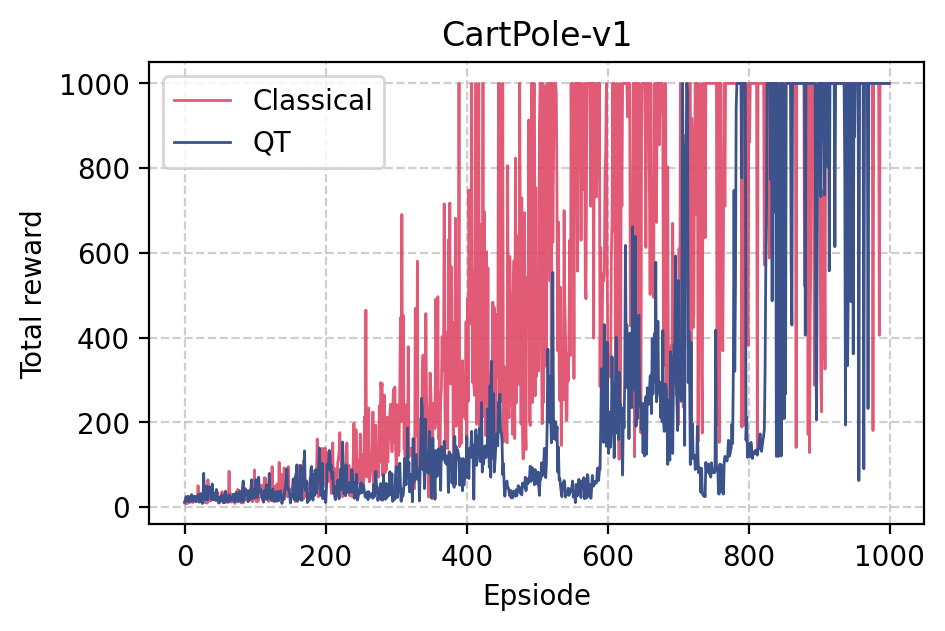

In [50]:
plt.figure(figsize=(5,3), dpi = 200)
plt.plot(total_reward_list ,color=plt.cm.magma(0.6), marker = "", markersize=2, lw = 1, alpha = 0.9, label = "Classical")
plt.plot(total_reward_list_qt ,color=plt.cm.viridis(0.25), marker = "", markersize=2, lw = 1, alpha = 1, label ="QT")

plt.title("CartPole-v1")
plt.xlabel("Epsiode")
plt.ylabel("Total reward")
plt.grid(True, linestyle='--', alpha = 0.6)
plt.legend()
# plt.xlim(len(fail_case_percentage_list) - 200, len(fail_case_percentage_list))
plt.show()

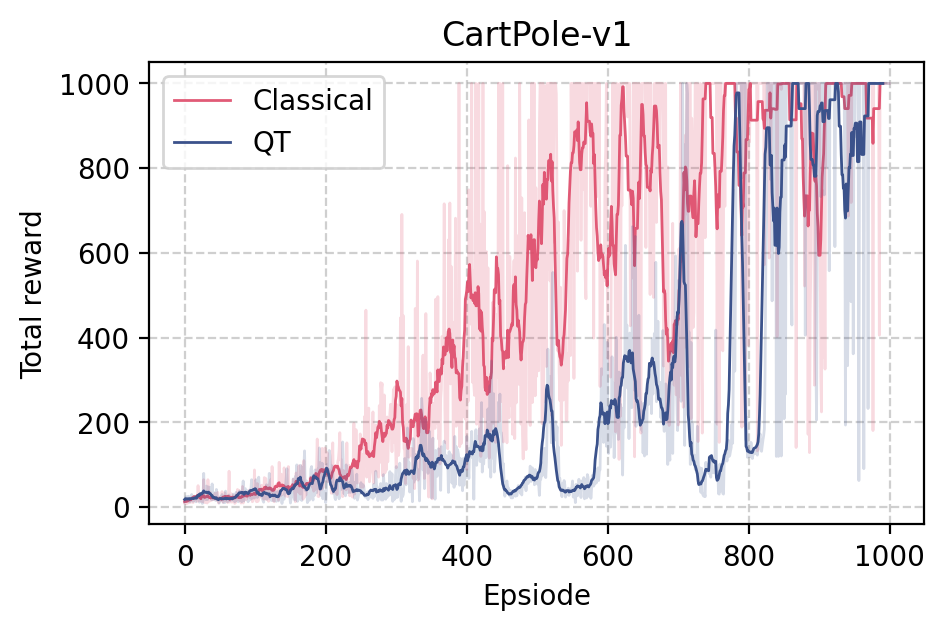

In [57]:
# Define a function to calculate the moving average
def moving_average(data, window_size=10):
    moving_avg = []
    for i in range(len(data) - window_size + 1):
        avg = sum(data[i:i+window_size]) / window_size
        moving_avg.append(avg)
    return moving_avg

# Calculate the moving average of the total rewards
window_size = 10
total_reward_list_qt_avg = moving_average(total_reward_list_qt, window_size)
total_reward_list_avg    = moving_average(total_reward_list, window_size)



plt.figure(figsize=(5,3), dpi = 200)
plt.plot(total_reward_list ,color=plt.cm.magma(0.6), marker = "", markersize=2, lw = 1, alpha = 0.2)#, label = "Classical")
plt.plot(total_reward_list_avg ,color=plt.cm.magma(0.6), marker = "", markersize=2, lw = 1, alpha = 0.9, label = "Classical")


plt.plot(total_reward_list_qt ,color=plt.cm.viridis(0.25), marker = "", markersize=2, lw = 1, alpha = 0.2)#, label ="QT")
plt.plot(total_reward_list_qt_avg ,color=plt.cm.viridis(0.25), marker = "", markersize=2, lw = 1, alpha = 1, label ="QT")



plt.title("CartPole-v1")
plt.xlabel("Epsiode")
plt.ylabel("Total reward")
plt.grid(True, linestyle='--', alpha = 0.6)
plt.legend()
# plt.xlim(len(fail_case_percentage_list) - 200, len(fail_case_percentage_list))
plt.show()